In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import requests
import cvxpy as cp
import apimoex
import seaborn as sns
from datetime import datetime, timedelta
from sklearn.covariance import LedoitWolf

# P.s Да в названии репо ошибка, но так ее никто из других кандидатов на стажировку не найдет)

# Задаем диапозон дат для выгрузки котировок

In [2]:
end = datetime.now().date()
start = end - timedelta(days=182)  # 6 месяцев

# 1. Получаем список голубых фишек MOEXBC через ISS statistics API
def get_imoex_constituents():
    url = (
        "https://iss.moex.com/iss/statistics/engines/stock/markets/index/analytics/MOEXBC.json"
    )
    j = requests.get(url).json()
    cols = [c.lower() for c in j['analytics']['columns']]
    df = pd.DataFrame(j['analytics']['data'], columns=cols)
    sec_col = next(c for c in df.columns if 'sec' in c or 'ticker' in c)
    return df[sec_col].tolist()

tickers = get_imoex_constituents()

print(f'Найдено тикеров: {len(tickers)}, \n{tickers}')

# 2. Загрузка сырых цен через apimoex
prices = pd.DataFrame()
with requests.Session() as session:
    for t in tickers:
        data = apimoex.get_board_history(session, t, start=start.isoformat(), end=end.isoformat())
        df_hist = pd.DataFrame(data)
        df_hist["TRADEDATE"] = pd.to_datetime(df_hist["TRADEDATE"])
        df_hist.set_index("TRADEDATE", inplace=True)
        prices[t] = df_hist["CLOSE"]

# Сохраняем сырые цены
# prices.to_csv('raw_prices.csv', index_label='date')


Найдено тикеров: 15, 
['CHMF', 'GAZP', 'GMKN', 'HEAD', 'LKOH', 'MOEX', 'NLMK', 'NVTK', 'PLZL', 'ROSN', 'SBER', 'SNGS', 'T', 'TATN', 'YDEX']


# Выгружаем сплиты если они были

In [3]:
# 3. Корректировка на сплиты
adj_prices = prices.copy()
all_splits = []

def fetch_splits(ticker):
    j = requests.get(
        f"https://iss.moex.com/iss/engines/stock/markets/shares/securities/{ticker}/corporate-actions.json"
    ).json()
    corp = j.get("corporateActions", {})
    data = corp.get("data") or []
    cols = corp.get("columns") or []
    if not data or not cols:
        return pd.DataFrame(columns=["ACTIONDATE","RATIO"])
    df = pd.DataFrame(data, columns=cols)
    if "ACTIONCODE" not in df or "RATIO" not in df:
        return pd.DataFrame(columns=["ACTIONDATE","RATIO"])
    return df[df["ACTIONCODE"].str.startswith("SP")][["ACTIONDATE","RATIO"]]

splits_records = []
for t in tickers:
    splits = fetch_splits(t)
    if not splits.empty:
        splits["ticker"] = t
        splits_records.append(splits)
        for _, row in splits.iterrows():
            dt_split = pd.to_datetime(row.ACTIONDATE)
            adj_prices.loc[adj_prices.index < dt_split, t] /= float(row.RATIO)

if splits_records:
    pd.concat(splits_records).to_csv('splits_summary.csv', index=False)
else:
    print('Сплиты за выбранный диапозон не найдены')

# Сохраняем скорректированные цены
# adj_prices.to_csv('adjusted_prices.csv', index_label='date')

Сплиты за выбранный диапозон не найдены


# Вычисляем доходность, ковариационную матрицу и строим MV портфель 

In [4]:
# 4. Доходности (только по скорректированным ценам)
returns = adj_prices.pct_change(fill_method=None).dropna()

# 5. Covariance & expected returns
lw = LedoitWolf().fit(returns)
Sigma = pd.DataFrame(lw.covariance_, index=returns.columns, columns=returns.columns) * 252
mu = returns.mean() * 252
print("\nExpected returns:\n", mu.round(4))

# 6. MV оптимизация
tickers = returns.columns.tolist()
n = len(tickers)
w = cp.Variable(n)
lam = 1

# Целевая функция Марковица
objective = cp.Maximize(mu.values @ w - lam * cp.quad_form(w, Sigma.values))
# Ограничения
constraints = [cp.sum(w) == 1, w >= 0.05, w <= 0.25]
prob = cp.Problem(objective, constraints)

try:
    result = prob.solve(solver=cp.ECOS, verbose=False)
    assert prob.status == "optimal"
except Exception as e:
    print(f"Optimization failed: {e}")
    exit()

# Извлекаем веса
w_opt = pd.Series(w.value, index=tickers).round(4)
print("\nOptimized weights:\n", w_opt)

# 7. Расчет показателей портфеля
RISK_FREE_RATE = 0.05

portf_ret = returns.dot(w_opt)
cum_ret = (1 + portf_ret).prod() - 1
n_years = len(returns) / 252
annualized_ret = (1 + cum_ret)**(1/n_years) - 1
annualized_vol = portf_ret.std() * np.sqrt(252)
sharpe_ratio = (annualized_ret - RISK_FREE_RATE) / annualized_vol

print(f"\nCumulative return: {cum_ret:.2%}")
print(f"Annualized Return (CAGR): {annualized_ret:.2%}")
print(f"Annualized Volatility: {annualized_vol:.2%}")
print(f"Sharpe Ratio: {sharpe_ratio:.2f}")   



Expected returns:
 CHMF    0.1615
GAZP    0.5851
GMKN    0.2195
HEAD   -0.3466
LKOH    0.0157
MOEX    0.3173
NLMK    0.3338
NVTK    0.9368
PLZL    0.4491
ROSN    0.0323
SBER    0.7932
SNGS   -0.0419
T       0.7984
TATN    0.7252
YDEX    0.5583
dtype: float64

Optimized weights:
 CHMF    0.05
GAZP    0.05
GMKN    0.05
HEAD    0.05
LKOH    0.05
MOEX    0.05
NLMK    0.05
NVTK    0.25
PLZL    0.05
ROSN    0.05
SBER    0.10
SNGS    0.05
T       0.05
TATN    0.05
YDEX    0.05
dtype: float64

Cumulative return: 21.89%
Annualized Return (CAGR): 56.10%
Annualized Volatility: 34.43%
Sharpe Ratio: 1.48


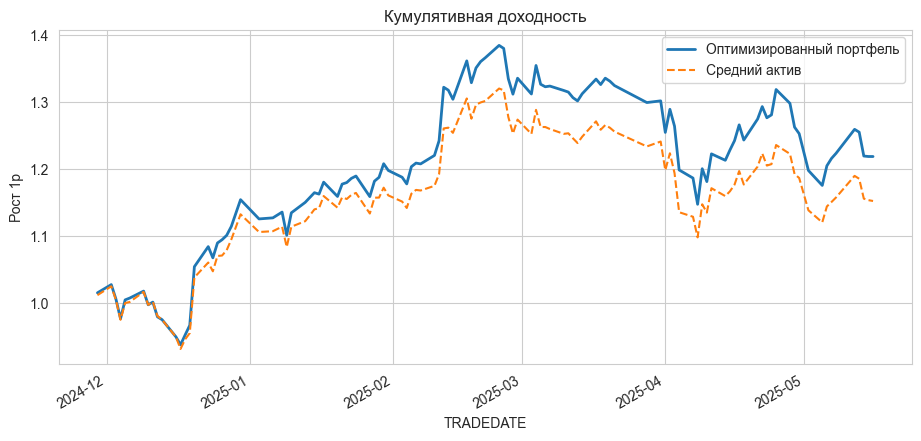

In [5]:
# 8. Визуализация результатов
sns.set_style('whitegrid')
plt.figure(figsize=(18, 8))

# График: Динамика портфеля vs отдельных активов
plt.subplot(2, 2, 1)
(portf_ret + 1).cumprod().plot(label='Оптимизированный портфель', lw=2)
(returns + 1).cumprod().mean(axis=1).plot(label='Средний актив', ls='--')
plt.title('Кумулятивная доходность')
plt.ylabel('Рост 1р')
plt.tight_layout()
plt.legend()